In [1]:
import yfinance as yf
import requests
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime as dt
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt


import pyfolio as pf
import matplotlib
import seaborn as sns
import pytz
import empyrical

/Users/bb/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [64]:
name = ['SPGI','VZ','TSLA','PG','DIS','SYY','AAPL','XOM','BRK-B','UNH']
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
df5 = pd.DataFrame()
df6 = pd.DataFrame()
df7 = pd.DataFrame()
df8 = pd.DataFrame()
df9 = pd.DataFrame()
df10 = pd.DataFrame()
d = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
for i in range(10):
  d[i] = yf.download(name[i],start = '2018-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [65]:
tolerance = 0.
look_back = 12
target_vol = 0.4
# Vol scaling

In [66]:
ret_m_index = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
std_index = d[0].resample('BM').last().index

In [67]:
for i in range(10):
    d[i]['returns'] = d[i].Close.pct_change()+1   
    returns = d[i]['returns']
    returns.dropna(inplace=True)
    ret_index = (returns).cumprod()
    ret_index[0] = 1
# equation (1) ex ante vol estimate
    day_vol = returns.ewm(ignore_na=False,
                          adjust=True,
                          com=60,   
                          min_periods=0).std(bias=False)
    vol = day_vol * np.sqrt(261) # annualise
    
    ret_index = pd.concat([ret_index, vol], axis=1)
    ret_index.columns = [name[i], 'vol']
# convert to monthly
    ret_m_index[i] = ret_index.resample('BM').last().ffill()

In [68]:
ret_m_index[1].head()

,VZ,vol
Date,,
2018-01-31,1.010088,0.176821
2018-02-28,0.891836,0.249461
2018-03-30,0.893331,0.204170
2018-04-30,0.921913,0.243074
2018-05-31,0.890529,0.226878


In [69]:
pnl = pd.DataFrame(index=std_index)
leverage = pd.DataFrame(index=std_index)
strategy_cumm_rtns = pd.DataFrame(index=std_index)

In [70]:
for j in range(10):
     #The pct_change() function is used to get percentage change between the current and a prior element.
    ret_m_index[j]['returns'] = ret_m_index[j][name[j]].pct_change(look_back)   
    ret_m_index[j]['pnl'] = 0
    ret_m_index[j]['leverage'] = 0
    ret_m_index[j]['position'] = 0
    
    for k, v in enumerate(ret_m_index[j]['returns']):
        if k <= look_back:
                # skip the first 12 observations
            continue
        if ret_m_index[j]['returns'].iloc[k-1] < tolerance:
                # negative returns, sell and hold for 1 mth, then close position
                
            ret_m_index[j]['position'].iloc[k] = -1
            ret_m_index[j]['pnl'].iloc[k] = (ret_m_index[j][name[j]].iloc[k - 1] / ret_m_index[j][name[j]].iloc[k] - 1) * target_vol / ret_m_index[j]['vol'].iloc[k - 1]
            ret_m_index[j]['leverage'].iloc[k] = target_vol / ret_m_index[j]['vol'].iloc[k - 1]
        elif ret_m_index[j]['returns'].iloc[k-1] > tolerance: #tolerance = 0
                # positive returns, buy and hold for 1 mth, then close position\
                
            ret_m_index[j]['position'].iloc[k] = 1
            ret_m_index[j]['pnl'].iloc[k] = (ret_m_index[j][name[j]].iloc[k] / ret_m_index[j][name[j]].iloc[k - 1] - 1) * target_vol / ret_m_index[j]['vol'].iloc[k - 1]
            ret_m_index[j]['leverage'].iloc[k] = target_vol / ret_m_index[j]['vol'].iloc[k - 1]

/Users/bb/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [71]:
ret_index = [0]*10
for i in range(10):
    ret_index[i] = (1 + ret_m_index[i]['pnl'][13:]).cumprod()
    ret_index[i][0] = 1

In [98]:
ret_m_index[0]

,SPGI,vol,returns,pnl,leverage,position
Date,,,,,,
2018-01-31,1.077207,0.143646,NaN,0.000000,0.000000,0
2018-02-28,1.140852,0.355722,NaN,0.000000,0.000000,0
2018-03-30,1.136450,0.305698,NaN,0.000000,0.000000,0
2018-04-30,1.121818,0.261993,NaN,0.000000,0.000000,0
2018-05-31,1.174756,0.224852,NaN,0.000000,0.000000,0
2018-06-29,1.212765,0.193150,NaN,0.000000,0.000000,0
2018-07-31,1.192244,0.193190,NaN,0.000000,0.000000,0
2018-08-31,1.231561,0.171341,NaN,0.000000,0.000000,0
2018-09-28,1.162206,0.184932,NaN,0.000000,0.000000,0


In [72]:
def tsmom_strategy(df, window = 252):
    df = df.copy()
    df['Original'] = np.log(df.Close.pct_change()+1)
    df['prior_n'] = df.Original.rolling(window).sum()
    df.dropna(inplace = True)
    df['position'] = [1 if i > 0 else -1 for i in df.prior_n]
    df['TSMOM Return'] = df.position.shift(1)*df.Original
    return df

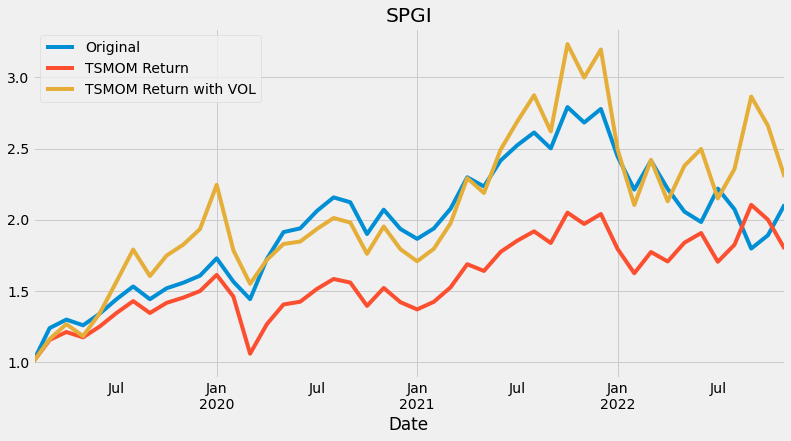

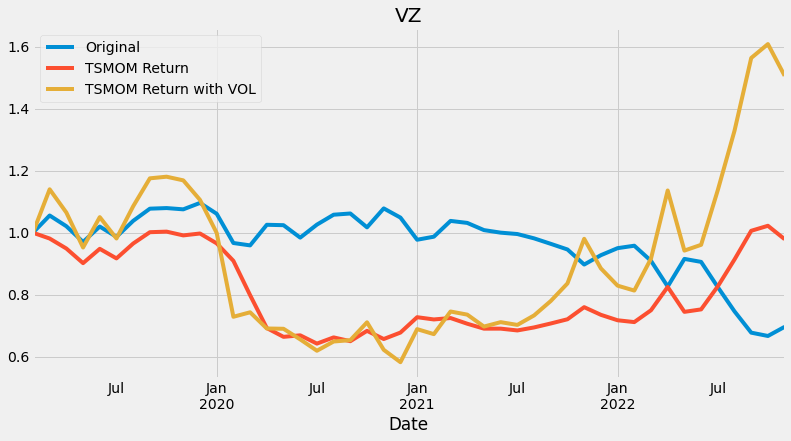

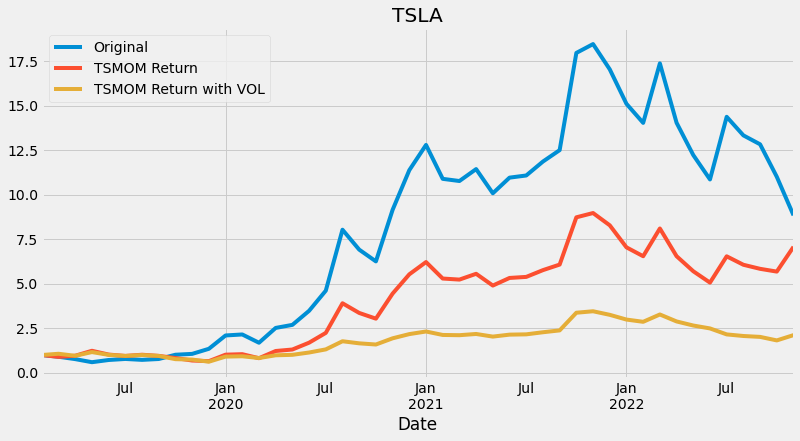

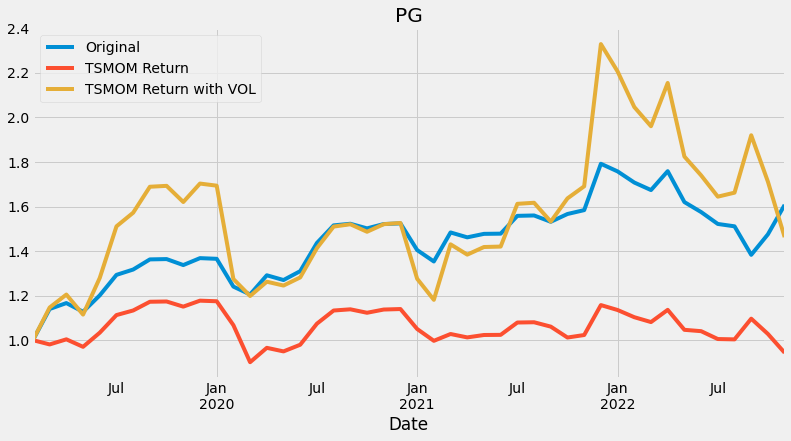

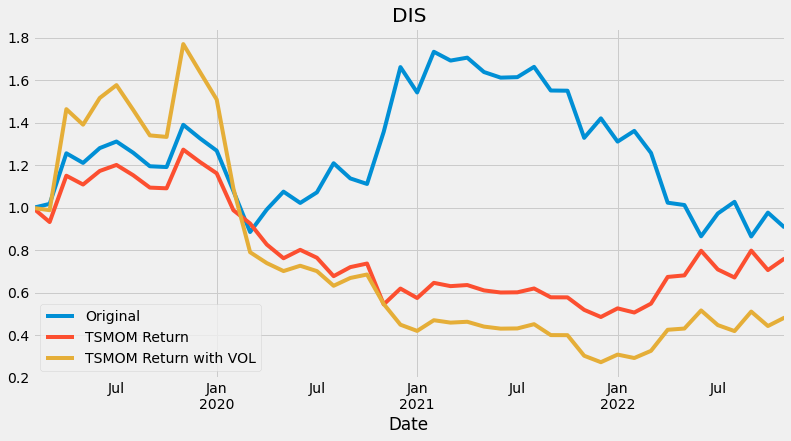

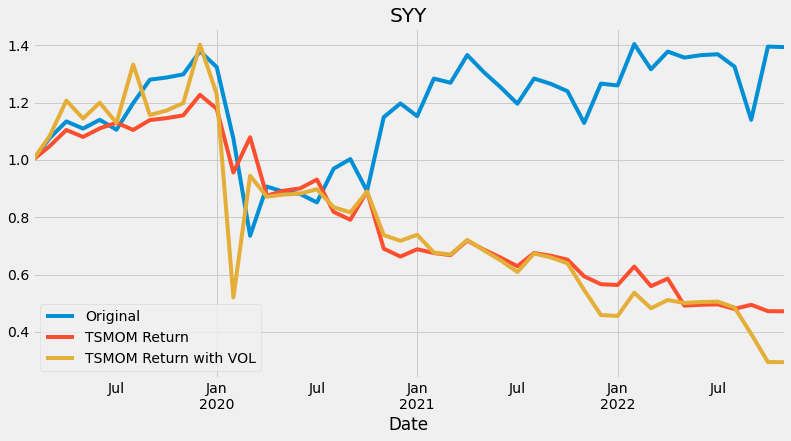

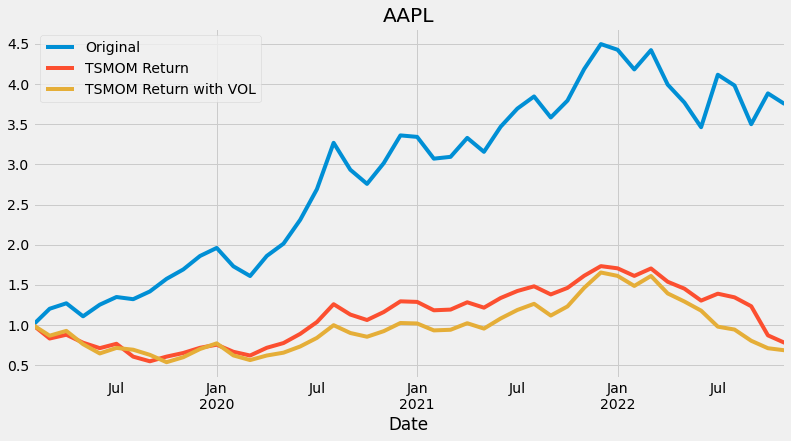

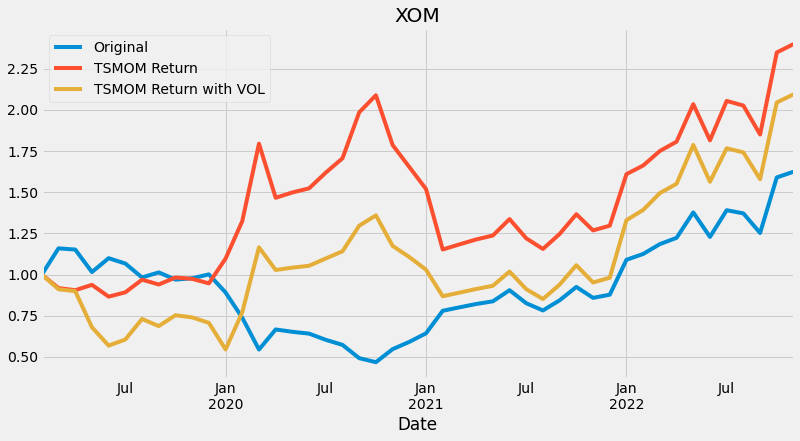

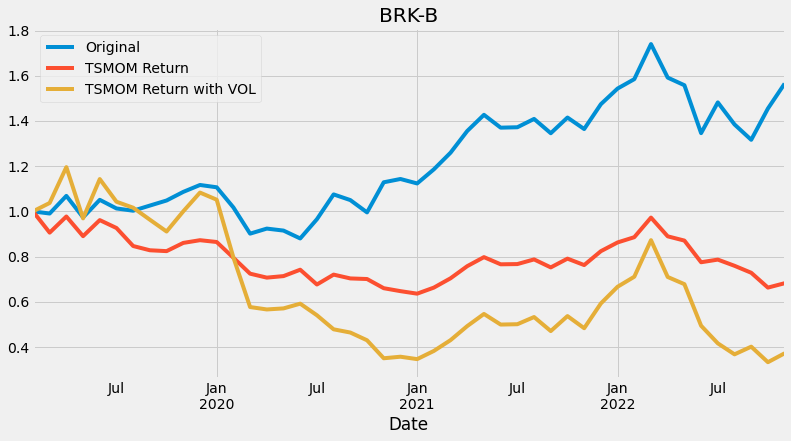

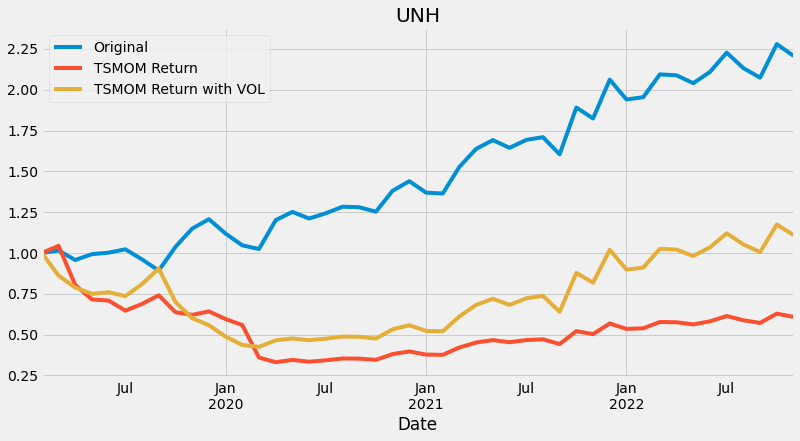

In [87]:
strategy = []
for i in range(10):
    df_new = tsmom_strategy(d[i])
    d_new = np.exp(df_new[['Original','TSMOM Return']].cumsum())
    d_new['close'] = d[i]['Close']
    ret_m = d_new.resample('BM').last().ffill()
    ret_m = ret_m[1:]
    ret_m.iloc[0][['Original','TSMOM Return']] = [1,1]
    ret_m['TSMOM Return with VOL'] = ret_index[i].values *
    ret_m['position'] = (ret_m_index[i]['position'][13:]).values
    strategy.append(ret_m)
    plt.style.use('fivethirtyeight')
    ret_m[['Original','TSMOM Return','TSMOM Return with VOL']].plot(figsize=(12,6))
    plt.title(name[i])
    plt.show()

In [88]:
all_pos = []
total = 10000
weights = [0.1, 0.1, 0.1, 0.1, 0.1 ,0.1, 0.1, 0.1, 0.1, 0.1]
for stock_df, allocation in zip(strategy,weights):
  stock_df['Allocation'] = stock_df['TSMOM Return with VOL'] * allocation
  stock_df['Position'] = stock_df['Allocation']*total
  all_pos.append(stock_df['Position'])

weights.append(1)
portf_val = pd.concat(all_pos, axis=1)
portf_val.columns = name
portf_val['Total Pos'] = portf_val.sum(axis=1)
portf_val

,SPGI,VZ,TSLA,PG,DIS,SYY,AAPL,XOM,BRK-B,UNH,Total Pos
Date,,,,,,,,,,,
2019-02-28,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,10000.000000
2019-03-29,1162.464883,1139.924986,1069.880226,1146.574165,989.176035,1083.123228,867.362787,910.906303,1037.259878,862.007939,10268.680431
2019-04-30,1267.083438,1064.984448,956.259838,1204.708558,1464.570584,1206.693880,927.266972,899.344551,1195.777881,788.160402,10974.850553
2019-05-31,1182.978954,952.320078,1165.092404,1114.714774,1391.672121,1144.200676,761.848971,680.459715,969.043691,749.880978,10112.212361
2019-06-28,1344.155885,1050.245560,1009.006272,1279.523714,1517.358396,1199.622101,646.283470,568.610005,1142.972792,759.930616,10517.708812
2019-07-31,1565.704835,981.305392,949.024763,1511.037385,1577.807290,1128.969213,715.212673,605.993581,1042.705537,735.810294,10813.570963
2019-08-30,1790.960608,1085.226849,999.369081,1572.352691,1461.331850,1332.583144,692.834002,730.535659,1016.244085,809.844548,11491.282515
2019-09-30,1605.026135,1175.299591,948.764194,1688.865303,1341.254899,1156.578312,628.834911,687.339690,963.156034,905.696819,11100.815888
2019-10-31,1748.964454,1180.555409,767.167595,1692.870088,1334.030146,1172.067969,537.467011,753.162970,910.989505,699.433469,10796.708617


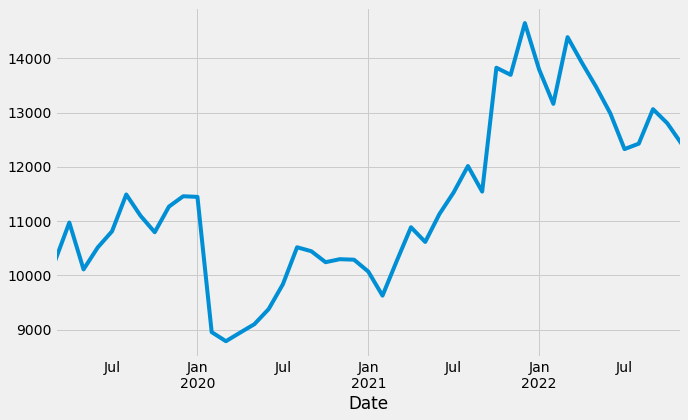

In [89]:
plt.style.use('fivethirtyeight')
n_l = len(portf_val['Total Pos'])
(portf_val['Total Pos'][1:n_l]).plot(figsize=(10,6))
plt.show()

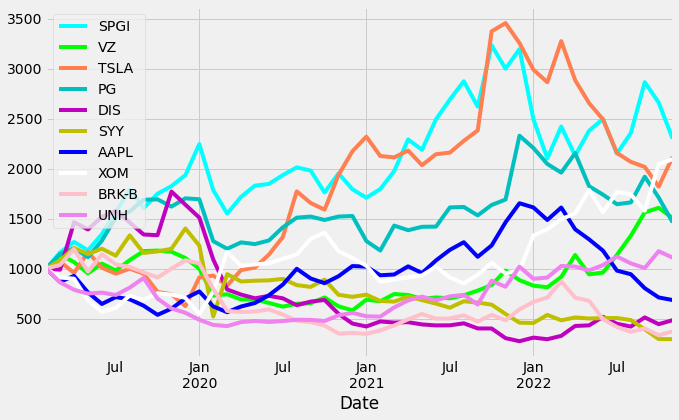

In [90]:
portf_val.drop('Total Pos', axis=1).plot(figsize=(10,6), color=['cyan', 'lime','coral', 'c', 'm', 'y', 'b', 'w','pink','violet'])
plt.show()

## Sharpe Ratio

In [76]:
i = 0
for p in portf_val:
    daily_return = portf_val[p].pct_change(1)
    daily_return.replace([np.inf, -np.inf], np.nan, inplace=True)
    daily_return.dropna(inplace=True)
    Sharpe_Ratio = daily_return.mean() /daily_return.std()
    A_Sharpe_Ratio = (252 ** 0.5)*Sharpe_Ratio
    cm_return = portf_val[p].iloc[-1]/portf_val[p].iloc[1]-1
    i = i + 1
    print(p)
    print('Sharp Ratio:' + str(round(Sharpe_Ratio,3)))
    print('Anual SR:   '    + str(round(A_Sharpe_Ratio,3)))
    print('Cumulative Return '+str(round(100*cm_return,3)) + '%')
    #print('Profit Gain by investing ' +str(invest) +" is "+str(round(invest*cm_return,3)) )
    print(' ')

SPGI
Sharp Ratio:0.217
Anual SR:   3.448
Cumulative Return 97.941%
 
VZ
Sharp Ratio:0.138
Anual SR:   2.196
Cumulative Return 32.108%
 
TSLA
Sharp Ratio:0.179
Anual SR:   2.848
Cumulative Return 97.865%
 
PG
Sharp Ratio:0.129
Anual SR:   2.052
Cumulative Return 27.571%
 
DIS
Sharp Ratio:-0.037
Anual SR:   -0.593
Cumulative Return -51.08%
 
SYY
Sharp Ratio:-0.064
Anual SR:   -1.009
Cumulative Return -72.801%
 
AAPL
Sharp Ratio:-0.017
Anual SR:   -0.274
Cumulative Return -20.959%
 
XOM
Sharp Ratio:0.176
Anual SR:   2.792
Cumulative Return 129.908%
 
BRK-B
Sharp Ratio:-0.099
Anual SR:   -1.576
Cumulative Return -64.113%
 
UNH
Sharp Ratio:0.073
Anual SR:   1.153
Cumulative Return 28.737%
 
Total Pos
Sharp Ratio:0.11
Anual SR:   1.745
Cumulative Return 21.017%
 


In [91]:
strategy[0]

,Original,TSMOM Return,close,TSMOM Return with VOL,position,Allocation,Position
Date,,,,,,,
2019-02-28,1.000000,1.000000,200.369995,1.000000,1,0.100000,1000.000000
2019-03-29,1.239623,1.156376,210.550003,1.162465,1,0.116246,1162.464883
2019-04-30,1.299146,1.211902,220.660004,1.267083,1,0.126708,1267.083438
2019-05-31,1.259229,1.174665,213.880005,1.182979,1,0.118298,1182.978954
2019-06-28,1.341124,1.251061,227.789993,1.344156,1,0.134416,1344.155885
2019-07-31,1.442155,1.345307,244.949997,1.565705,1,0.156570,1565.704835
2019-08-30,1.531881,1.429008,260.190002,1.790961,1,0.179096,1790.960608
2019-09-30,1.442331,1.345472,244.979996,1.605026,1,0.160503,1605.026135
2019-10-31,1.518928,1.416925,257.989990,1.748964,1,0.174896,1748.964454


## P/L

In [93]:
tsmom_strategy_ret_df = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
tsmom_investment_ret_df = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
total_investment_ret = [0]*10

In [94]:
# total investment_value $1 million
# calculate return 
for j in range(10):
    df_ret = pd.DataFrame(np.diff(strategy[j]['close'])).rename(columns = {0:'returns'})
    tsmom_strategy_ret = []
    
    for i in range(len(df_ret)):
        returns = df_ret['returns'][i]*(strategy[j]['position'][i])
        tsmom_strategy_ret.append(returns)
    
    tsmom_strategy_ret_df[j] = pd.DataFrame(tsmom_strategy_ret).rename(columns = {0:'tsmom_returns'})

    # calculate investement return 
    investment_value = 100000
    number_of_stocks = floor(investment_value/(strategy[j]['close'][0]))
    tsmom_investment_ret = []
    
    for i in range(len(tsmom_strategy_ret_df[j]['tsmom_returns'])):
        returns = number_of_stocks*tsmom_strategy_ret_df[j]['tsmom_returns'][i]
        tsmom_investment_ret.append(returns)
    
    tsmom_investment_ret_df[j] = pd.DataFrame(tsmom_investment_ret).rename(columns = {0:'investment_returns'})
    total_investment_ret[j] = round(sum(tsmom_investment_ret_df[j]['investment_returns']), 2)

In [95]:
total_investment_ret

[70199.33,
 -4776.32,
 719223.89,
 31038.54,
 -19465.41,
 -69915.2,
 191504.73,
 64363.18,
 -28544.79,
 100569.19]

In [96]:
for i in range(10):
    investment_value = 100000
    profit_percentage = floor((total_investment_ret[i]/investment_value)*100)
    print(cl('Profit gained from the TSMOM strategy by investing $100k in {} : {}'.format(name[i],total_investment_ret[i]), attrs = ['bold']))
    print(cl('Profit percentage of the TSMOM strategy: {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the TSMOM strategy by investing $100k in SPGI : 70199.33
Profit percentage of the TSMOM strategy: 70%
Profit gained from the TSMOM strategy by investing $100k in VZ : -4776.32
Profit percentage of the TSMOM strategy: -5%
Profit gained from the TSMOM strategy by investing $100k in TSLA : 719223.89
Profit percentage of the TSMOM strategy: 719%
Profit gained from the TSMOM strategy by investing $100k in PG : 31038.54
Profit percentage of the TSMOM strategy: 31%
Profit gained from the TSMOM strategy by investing $100k in DIS : -19465.41
Profit percentage of the TSMOM strategy: -20%
Profit gained from the TSMOM strategy by investing $100k in SYY : -69915.2
Profit percentage of the TSMOM strategy: -70%
Profit gained from the TSMOM strategy by investing $100k in AAPL : 191504.73
Profit percentage of the TSMOM strategy: 191%
Profit gained from the TSMOM strategy by investing $100k in XOM : 64363.18
Profit percentage of the TSMOM strategy: 64%
Profit gained from the TSMOM str

In [97]:
all_investment_value = 1000000
all_investment_ret = round(sum(total_investment_ret), 2)
all_profit_percentage = floor((all_investment_ret/all_investment_value)*100)
print(cl('Profit gained from the TSMOM strategy by investing 1 million in portfolio : {}'.format(all_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the TSMOM strategy: {}%'.format(all_profit_percentage), attrs = ['bold']))

Profit gained from the TSMOM strategy by investing 1 million in portfolio : 1054197.14
Profit percentage of the TSMOM strategy: 105%
